In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, f1_score
import math
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# Function to read data from a file and return a list of lines
def read_data(file_name):
    # Open the file with the specified encoding
    with open(file_name, "r", encoding='utf-8') as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    return content

# Read text data from the file and store it
train_text = read_data("train_text.txt")
train_labels = read_data("train_labels.txt")
val_text = read_data("val_text.txt")
val_labels = read_data("val_labels.txt")
test_text = read_data("test_text.txt")
test_labels = read_data("test_labels.txt")

In [3]:
# train_labels,train_text

In [4]:
# val_labels,val_text

In [5]:
# test_labels,test_text

In [6]:
def read_lexicons(file_name):
    with open(file_name, "r", encoding='utf-8') as f:
        content = f.readlines()
    content = [x.strip().split('\t') for x in content]
    lexicon_dict = {values[0]: {'Negative': float(values[1]), 'Positive': float(values[2])} for values in content if len(values) == 3}

    return lexicon_dict

# Add file names for socialsent_hist_adj and socialsent_hist_freq 2000.tsv
hist_adj_file = "socialsent_hist_adj/2000.tsv"
hist_freq_file = "socialsent_hist_freq/2000.tsv"

# Read the sentiment lexicons from the 2000.tsv files
hist_adj_lexicon = read_lexicons(hist_adj_file)
hist_freq_lexicon = read_lexicons(hist_freq_file)

# Read subreddit lexicons
lexicon_files = [
   "3DS.tsv", "4chan.tsv", "2007scape.tsv", "ACTrade.tsv", "amiugly.tsv", "BabyBumps.tsv", "baseball.tsv", "canada.tsv",
    "CasualConversation.tsv", "DarknetMarkets.tsv", "darksouls.tsv", "elderscrollsonline.tsv", "Eve.tsv", "Fallout.tsv",
    "fantasyfootball.tsv", "GameDeals.tsv", "gamegrumps.tsv", "halo.tsv", "Homebrewing.tsv", "IAmA.tsv", "india.tsv",
    "jailbreak.tsv", "Jokes.tsv", "KerbalSpaceProgram.tsv", "Keto.tsv", "leagueoflegends.tsv", "Libertarian.tsv",
    "magicTCG.tsv", "MakeupAddiction.tsv", "Naruto.tsv", "nba.tsv", "oculus.tsv", "OkCupid.tsv", "Parenting.tsv",
    "pathofexile.tsv", "raisedbynarcissists.tsv", "Random_Acts_Of_Amazon.tsv", "science.tsv", "Seattle.tsv",
    "TalesFromRetail.tsv", "talesfromtechsupport.tsv", "ultrahardcore.tsv", "videos.tsv", "Warthunder.tsv",
    "whowouldwin.tsv", "xboxone.tsv", "yugioh.tsv"
]

lexicon_dicts = []
for file in lexicon_files:
    lexicon_dicts.append(read_lexicons(os.path.join("socialsent_subreddits", file)))

# Combine all lexicons into a single list
all_lexicons = [hist_adj_lexicon, hist_freq_lexicon] + lexicon_dicts


In [7]:
# for index, lexicon in enumerate(all_lexicons):
#     print(f"Lexicon {index + 1}:\n")
#     for i, (word, scores) in enumerate(lexicon.items()):
#         if i >= 100:
#             break
#         print(f"{word}: Negative {scores['Negative']}, Positive {scores['Positive']}")
    
#     print()


In [8]:
def extract_features(tweet, all_lexicons):
    words = tweet.split()
    word_count = len(words)
    longest_word = max(words, key=len)

    features = [0] * 12
    for i, lexicon_dict in enumerate(all_lexicons[:9]):
        score = sum([lexicon_dict.get(word, {'Negative': 0, 'Positive': 0})['Negative'] + 
                     lexicon_dict.get(word, {'Negative': 0, 'Positive': 0})['Positive']
                     for word in words])
        features[i] = score

    features[9] = math.log(word_count) if word_count > 0 else 0
    features[10] = math.log(len(longest_word)) if longest_word else 0
    long_word_count = len([word for word in words if len(word) >= 5])
    features[11] = math.log(long_word_count) if long_word_count > 0 else 0

    return features

train_features = [extract_features(tweet, all_lexicons) for tweet in train_text]
val_features = [extract_features(tweet, all_lexicons) for tweet in val_text]
test_features = [extract_features(tweet, all_lexicons) for tweet in test_text]


In [9]:
# train_features

In [10]:
# val_features

In [11]:
# test_features

In [12]:
# Convert the list of training features and labels to PyTorch tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train = torch.tensor(list(map(int, train_labels)), dtype=torch.float32).view(-1, 1)

# Convert the list of validation features and labels to PyTorch tensors
X_val = torch.tensor(val_features, dtype=torch.float32)
y_val = torch.tensor(list(map(int, val_labels)), dtype=torch.float32).view(-1, 1)

# Convert the list of test features and labels to PyTorch tensors
X_test = torch.tensor(test_features, dtype=torch.float32)
y_test = torch.tensor(list(map(int, test_labels)), dtype=torch.float32).view(-1, 1)



In [13]:
class LogisticRegression:
    def __init__(self, num_features):
        self.weights = Variable(torch.randn(num_features, 1), requires_grad=True)
        self.bias = Variable(torch.randn(1), requires_grad=True)

    def forward(self, X):
        return torch.sigmoid(torch.mm(X, self.weights) + self.bias)

    def train(self, X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
        train_losses = []
        val_accuracies = []
        val_f1_scores = []

        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            loss = torch.mean(-y_train * torch.log(y_pred) - (1 - y_train) * torch.log(1 - y_pred))
            train_losses.append(loss.item())
            loss.backward()

            with torch.no_grad():
                self.weights -= lr * self.weights.grad
                self.bias -= lr * self.bias.grad
                self.weights.grad.zero_()
                self.bias.grad.zero_()

            val_accuracy, val_f1 = self.evaluate(X_val, y_val)
            val_accuracies.append(val_accuracy)
            val_f1_scores.append(val_f1)

        return train_losses, val_accuracies, val_f1_scores

    def predict(self, X):
        return (self.forward(X) >= 0.5).float()

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')
        return accuracy, f1


In [14]:
Model = LogisticRegression(num_features=12)
train_losses, val_accuracies, val_f1_scores = Model.train(X_train, y_train, X_val, y_val, lr=0.001, epochs=100)
accuracy, f1 = Model.evaluate(X_test, y_test)
print(f"Accuracy using Logistic Regression: {accuracy:.4f}")
print(f"F1 Score of the logistic regression Model: {f1:.4f}")


Accuracy using Logistic Regression: 0.3233
F1 Score of the logistic regression Model: 0.1580


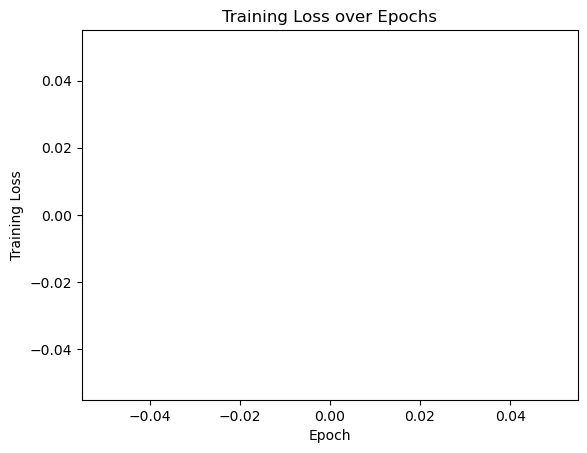

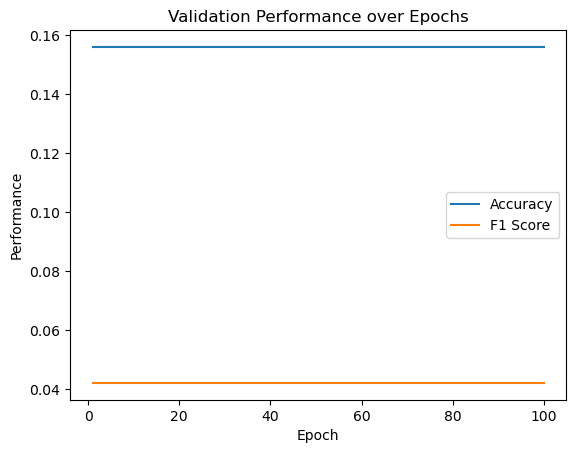

In [15]:
# Plot training loss over epochs
plt.figure()
plt.plot(range(1, 101), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot validation accuracy and F1 score over epochs
plt.figure()
plt.plot(range(1, 101), val_accuracies, label='Accuracy')
plt.plot(range(1, 101), val_f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Validation Performance over Epochs')
plt.legend()
plt.show()